<h1>"Among Us" Dataset - Technical Report

<h2>Introduction

Among Us is a game involving many variables and strategies. It's simple yet complex set of rules makes it a really interesting game and allows us to perform many types of analysis. <br>
The game is similar to the popular game of "Mafia". A group of players first enter a lobby and the game then begins. In every round, a majority of the players are picked as "Crewmates", the good guys of the game, and 1-3 players can be picked as "Imposters" (the bad guys). The crewmates must complete a number of tasks within a given time limit in order to win, whereas, the imposters' goal is to kill all the crewmates before they complete the tasks. Imposters are also able to "Sabotage" parts of the location, like cause problems in the reactor or oxygen supply; when sabotaged, the crewmates must immediately fix the problem as waiting too long will end the game. The game will consist of Rounds, where a new round begins when a dead body is found or someone calls an "Emergency Meeting". At the end of each round the players talk and discuss the activities they did and if they suspect any other player to be an imposter, if enough people vote for a player to be thrown off, the player is ejected and it's game over for them. The imposters must lie and pretend to be crewmates and try to vote others off.<br>
There are many strategic approaches to go with in this game and this dataset allows us to analyse many things, such as, what kind of plays were more likely to yield victories for "Crewmates" and "Imposters".

In this report, we plan on answering the following questions using the selected dataset: <br>
  1. Does voting out imposters significantly increase your chance of winning compared to doing all your tasks?<br>
  2. Is it easier to win as a crewmate or as an imposter? <br>
  3. Does completing more tasks increase your chances of getting murdered?<br>
  4. How often are players able to correctly vote out imposters? <br>
  5. Does fixing sabotages increase your chances of dying?

This report's workload was distributed between involved members.
Dewan was responsible for writing the introduction, potential data science, and answering questions with exploratory data analysis. Sameer was responsible for writing the discussion in exploratory data analysis, the conclusion, and part of the blog post. David was responsible for the data outline, data analysis and cleanup, graphing and coding in exploratory data analysis, and part of the blog post.

<h2>Dataset Outline
<p> The specific dataset we chose to study is <a href="https://www.kaggle.com/ruchi798/among-us-dataset">"Among Us Dataset"</a> by Ruchi Bhatia on Kaggle. This data was recorded from games of Among Us by Bhatia and posted to Kaggle. The dataset itself is composed of multiple CSV files, each corresponding to a different player.

<h2><br>Data Analysis
<p>This dataset contains 13 unique columns by default:
<br><b>Game Completed Date</b> - The exact date and time each recorded game ended.
<br><b>Team</b> - "Crewmate" or "Imposter", denotes the player's objective for that game.
<br><b>Outcome</b> - "Win" or "Loss", denotes whether the player won that game.
<br><b>Task Completed</b> - The number of tasks the player completed.
<br><b>All Tasks Completed</b> - "Yes", "No" or left empty if "Team" is "Imposter". Denotes whether the player completed all of their tasks.
<br><b>Murdered</b> - Only filled if "Team" is "Crewmate". Whether the player was killed by an imposter.
<br><b>Imposter Kills</b> - Only filled if "Team" is "Imposter". Denotes the number of crewmates the player killed.
<br><b>Game Length</b> - The length of the recorded game. (XXm XXs)
<br><b>Ejected</b> - "Yes" or "No". Whether they were voted out by other players.
<br><b>Sabotages Fixed</b> - Denotes the number of sabotages the player fixed. (While imposters can technically fix sabotages, imposter games were recorded as "N/A".) 
<br><b>Time to complete all tasks</b> - Only filled if "All Tasks Completed" is "Yes". (XXm XXs)
<br><b>Rank Change</b> - Denotes the change in rank after a game.
<br><b>Region/Game Code</b> - Denotes the server region and game code. Region will always be "NA" or "Europe" (Region / GMCODE).

<p>The entire dataset is composed of game information recorded by 29 players separated into 29 CSV files. The CSV files have varying numbers of entries ranging from 31 to 100.

<p><br>This dataset, while easy to read, is difficult to analyze as it is now. There are multiple things we can do to make the dataset easier to analyze. To start, since each user's data is in a seperate CSV file, we can merge each file into one large DataFrame and add a new column which denotes which file each entry came from. It may also be useful to parse each numeric column into integers and dates into datetimes. We may want to switch all "N/A" and "-" to 0 in "Sabotages Fixed" and simply drop all "Imposter" games when analyzing these. Many of the timed metrics could be switched to integers measured in seconds rather than minutes and seconds.

In [ ]:
# Import libraries
import csv
import re
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV data into a dictionary
def get_data_csv():
  master = []
  collection = []
  for i in range(1,30):
    with open('User{0}.csv'.format(i), 'r') as f:
          for line in csv.DictReader(f):
              collection.append(line)
          master.append(collection.copy())
          collection = []
  return master

# Save dictionary to a variable
data = get_data_csv()

# Make DataFrame to store information 
df = pd.DataFrame()

# Merge all files to one DataFrame
for i in range(len(data)):
  # Add new column "User" to denote original file
  df = pd.concat([df, pd.DataFrame(data[i]).assign(User=i+1)])

df.head(3)

,﻿Game Completed Date,Team,Outcome,Task Completed,All Tasks Completed,Murdered,Imposter Kills,Game Length,Ejected,Sabotages Fixed,Time to complete all tasks,Rank Change,Region/Game Code,User
0,12/13/2020 at 1:26:56 am EST,Crewmate,Win,3,No,Yes,-,07m 04s,No,2,-,++,NA / WYMSBF,1
1,12/13/2020 at 1:17:42 am EST,Crewmate,Loss,7,Yes,No,-,16m 21s,No,1,09m 48s,--,NA / WYMSBF,1
2,12/13/2020 at 12:57:47 am EST,Crewmate,Win,3,No,No,-,11m 33s,No,0,-,++,NA / WYMSBF,1


In [ ]:
# Removing all strings from numerical categories
numeric_categories = [
  'Task Completed', 
  'Imposter Kills', 
  'Sabotages Fixed',
  'Game Length',
  'Time to complete all tasks'
]

for category in numeric_categories:
  df = df.replace({category: r'N\/A|-'}, {category: '0'}, regex=True)

# Convert to seconds
second_categories = [
  'Game Length',
  'Time to complete all tasks'
]

def func(x):
  total = 0
  p = zip([60, 1], map(int, x.split(' ')))
  for s,t in p:
    total += s*t
  return str(total)

for category in second_categories:
  df = df.replace({category: r'[ms]'}, {category: ''}, regex=True)
  df[category] = df.get(category).map(func)

# Changing to int32
for category in numeric_categories:
  df = df.astype({category: np.int32})

# Changing "﻿Game Completed Date" to datetime "Game Completed Date"
df.insert(0, 'Game Completed Date', pd.to_datetime(
    df.get('﻿Game Completed Date'), format='%m/%d/%Y at %I:%M:%S %p %Z')
)
df.drop(columns='﻿Game Completed Date', inplace=True)


df.dtypes

Game Completed Date           datetime64[ns, EST]
Team                                       object
Outcome                                    object
Task Completed                              int32
All Tasks Completed                        object
Murdered                                   object
Imposter Kills                              int32
Game Length                                 int32
Ejected                                    object
Sabotages Fixed                             int32
Time to complete all tasks                  int32
Rank Change                                object
Region/Game Code                           object
User                                        int64
dtype: object

In [ ]:
df.head()

,Game Completed Date,Team,Outcome,Task Completed,All Tasks Completed,Murdered,Imposter Kills,Game Length,Ejected,Sabotages Fixed,Time to complete all tasks,Rank Change,Region/Game Code,User
0,2020-12-13 01:26:56-05:00,Crewmate,Win,3,No,Yes,0,424,No,2,0,++,NA / WYMSBF,1
1,2020-12-13 01:17:42-05:00,Crewmate,Loss,7,Yes,No,0,981,No,1,588,--,NA / WYMSBF,1
2,2020-12-13 00:57:47-05:00,Crewmate,Win,3,No,No,0,693,No,0,0,++,NA / WYMSBF,1
3,2020-12-13 00:41:55-05:00,Imposter,Win,0,-,-,2,485,No,0,0,+++,Europe / QIRTNF,1
4,2020-12-13 00:30:37-05:00,Crewmate,Loss,4,No,No,0,310,No,0,0,---,Europe / QIRTNF,1


<h2>Exploratory Data Analysis
<br><h3>1. Does voting out imposters significantly increase your chance of winning 
compared to doing all your tasks?

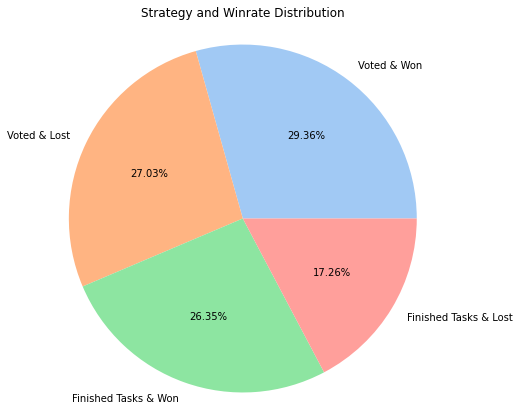

In [ ]:
# TODO
#   - Filter games by 'Crewmate'
#   - Compare "All Tasks Completed" and "Outcome" values

crewmate = df[df['Team'] == 'Crewmate']
one = crewmate[['All Tasks Completed', 'Outcome']]
x = [0, 0, 0, 0]

for i in range(0, len(one)):
  j = 0
  j += (0 if one.iloc[i, 0] == 'No' else 2)   # All Tasks Completed
  j += (0 if one.iloc[i, 1] == 'Win' else 1)  # Outcome
  x[j] += 1
total = sum(x)
x = list(map(lambda y: (y/total * 100), x))
plt.pie(x=x, 
        labels=['Voted & Won', 
                'Voted & Lost', 
                'Finished Tasks & Won', 
                'Finished Tasks & Lost'], 
        colors=sns.color_palette('pastel')[0:4], radius=2, autopct="%.2f%%")
plt.title("Strategy and Winrate Distribution", y=1.4)
plt.show()

To analyse the data more visually regarding the win rate depending on if you voted or completed tasks, a pie chart is used which is also color coded.  Looking at this data analysis pie chart, it shows the win rate by voting the imposter out is 29.3% which is the higher win rate compared to doing the tasks which was 26.4%. But on the other hand the loss rate of voting (27.03%) is way higher than the loss rate of losing (17.26%).

Conclusion: Working together to vote the imposter out it is the best chance to win the game, but if you taskmates want to play it safe and complete the set out tasks you have a extremely less likely chance of losing the game.

<br><h3>2. Is it easier to win as a crewmate or as an imposter?

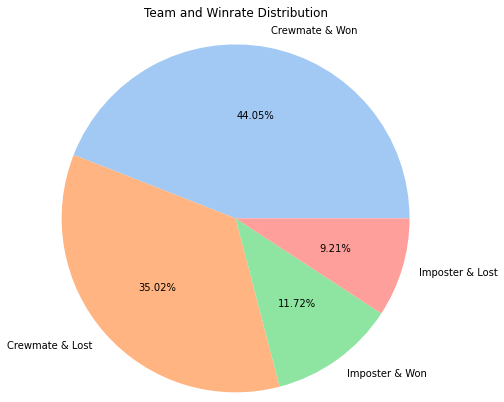

In [ ]:
# TODO
#   - Compare "Team" and "Outcome" values

two = df[['Team', 'Outcome']]
x = [0, 0, 0, 0]

for i in range(0, len(two)):
  j = 0
  j += (0 if two.iloc[i, 0] == 'Crewmate' else 2)   # Team
  j += (0 if two.iloc[i, 1] == 'Win' else 1)        # Outcome
  x[j] += 1
total = sum(x)
x = list(map(lambda y: (y/total * 100), x))
plt.pie(x=x, 
        labels=['Crewmate & Won', 
                'Crewmate & Lost', 
                'Imposter & Won', 
                'Imposter & Lost'], 
        colors=sns.color_palette('pastel')[0:4], radius=2, autopct="%.2f%%")
plt.title("Team and Winrate Distribution", y=1.4)
plt.show()

To analyse the data more visually regarding the win rate depending on if you are imposter or crewmate,a pie chart is used which is also color coded. Firstly, looking at the pie chart used to analyse this specific scenario, it is very clear that being a crewmate you have the highest win rate (44.1%) but also the highest losing rate (35%). Secondly, being imposter the win rate is low (11.7%) but not too much different from the losing rate (9.2%)

Conclusion: Being a crewmate you have a significantly higher winrate due to numbers (multiple crewmates and maximum 2 imposters). BUT this high winrate is couples with a high losing rate so that means your chances of winning weigh highly on you having a capable set of crewmates that can work together to a  win. Now looking at the imposter loss/win percentage it seems it is very dependent on the specific ability of the imposter to win or lose.

<br><h3>3. Does completing more tasks increase your chances of getting murdered?

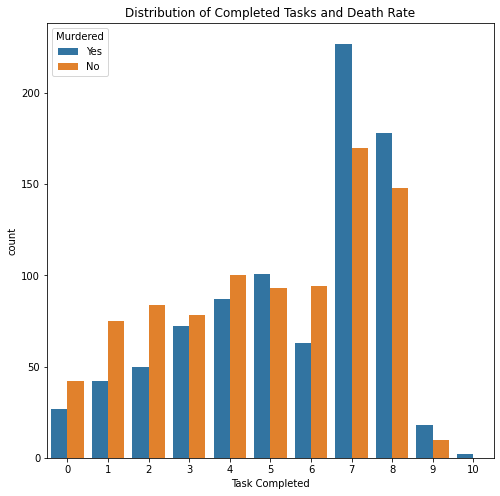

In [ ]:
# TODO
#   - Filter games by 'Crewmate'
#   - Compare "Task Completed" and "Murdered" values

three = crewmate[['Task Completed', 'Murdered']]
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.countplot(data=three, x='Task Completed', hue="Murdered")
ax.set_title("Distribution of Completed Tasks and Death Rate");

To analyse the data more visually regarding the correlation between # of tasks completed and the likelihood of getting murdered,a bar graph is used which is also color coded.
From a range of 0 tasks to 10 it seems that normally up to completing 1-6 tasks you are not murdered, but after 6+ tasks the rate of dying significantly increases.

<br> Conclusion: By trying to survive to the end game doing tasks throughout increases your chance of dying by alot especially as less and less crewmembers are alive by doing 6+ tasks its more likely for you to die by an imposter.

<br><h3>4. How often are players able to correctly vote out imposters?

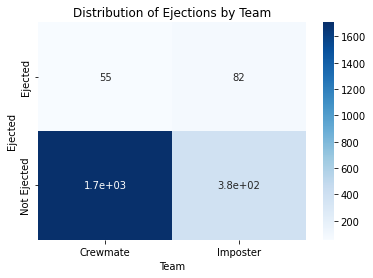

In [ ]:
# TODO
#   - Compare "Ejected" and "Team" values

four = df[['Ejected', 'Team']]
x = [0, 0, 0, 0]

for i in range(0, len(four)):
  j = 0
  j += (0 if four.iloc[i, 0] == 'Yes' else 2)       # Ejected
  j += (0 if four.iloc[i, 1] == 'Crewmate' else 1)  # Team
  x[j] += 1
total = sum(x)
n = np.array(x).reshape(2,2)

ax = sns.heatmap(n, annot=True, cmap='Blues')
ax.set_ylabel('Ejected')
ax.set_xlabel('Team')

ax.yaxis.set_ticklabels(['Ejected', 'Not Ejected'])
ax.xaxis.set_ticklabels(['Crewmate', 'Imposter'])
ax.set_title("Distribution of Ejections by Team");

plt.show()

To analyse the data more visually to see the number of ejections by team to their own crewmate or to an imposter a heatmap was used.

<br> During these games there is alot of voting to weed out imposters many times teammembers are in disagreement to who is an imposter to be ejected. But overall it looks that 64% of the time the teammates are able to correctly vote out the imposter. We came to that parecentage by looking at the amount of time innocent crewmate were ejected (55) and the amount of time imposters were ejected (82) 55/82 = 0.64 x 100 = 64% which is a very good imposter detection/ejection rate.

<br> Conclusions: Yes, 6 out of 10 times teammates correctly vote out the imposters.

<br><h3>5. Does fixing sabotages increase your chances of dying?

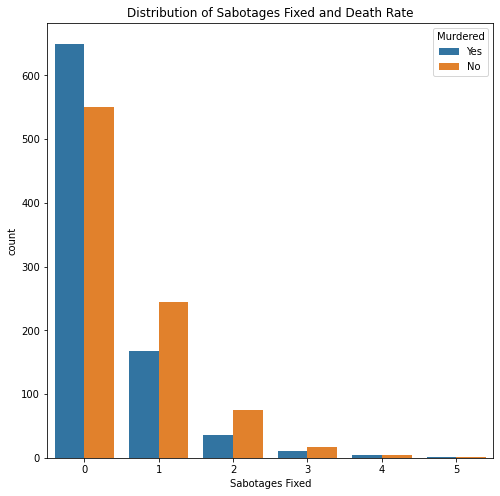

In [ ]:
# Does fixing sabotages increase your chances of dying?

# TODO
#   - Filter by crewmate
#   - Compare "Murdered" and "Sabotages Fixed" values

five = crewmate[['Murdered', 'Sabotages Fixed']]
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.countplot(data=five, x='Sabotages Fixed', hue="Murdered")
ax.set_title("Distribution of Sabotages Fixed and Death Rate");

To analyse the data more visually to see the correlation between fixing the sabotages and the rate of dying by an imposter a bar chart was used.

<br>Looking at the bar chart it seems that NOT fixing the sabotages the rate of dying by an imposter was extremely high. When fixing one or more sabotage the rate of dying was drastically less.

Conclusion: I will be able to conclude that fixing the sabotages you have a better chance of surviving that would be because when you are fixing the sabotages with you teammates you guys are able to deter the imposter from attempting to kill because if the imposter tried to the other teammate next to you would report the imposter just as you died. On the other hand if u stick to doing tasks and are seperated from your teammates fixing the sabotage then the imposter will have a easier chance of killing you.

<br><h3>Reflection
<p>After sorting through and analyzing the dataset, there were a few unexpected problems that made it significantly harder to analyze. First of all, and most prominently, when analyzing the data, we ran into a problem in which the first column was named '﻿Game Completed Date' with an odd symbol at the beginning. It isn't visible in the formatted report, but in the markdown editor, you can see it. This symbol was never shown in the Kaggle Dataset or when printing the DataFrame, so this caused lots of trouble when attempting to refer to its column.
<br>Changing time measurements to integer seconds was also an interesting challenge, though it was relatively straightforward compared to the first issue.

<h2>Potential Data Science
<p> The dataset and its analysis touches a wide variety of information and patterns associated with it. Using machine learning, we can teach a machine to look at different variables and situations and make it take the best course of action in order to win. <br>
<br>
For example, when <b>Crewmate</b>, the AI could determine whether to focus on completing Tasks or try to roam and find the imposter and vote them out, at specific points of the game. In our analysis, we saw that the chance of death increases as the number of tasks done by a player increases. The chance of death significantly rises after completing 6 out of 8 tasks. So the AI may wish to stop focusing too much on tasks and observe the areas and other players if the majority of crewmates have already died. <br>
<br>
As an <b>Imposter</b>, the AI can predict at which point in the game it is most risky for an imposter to be identified or voted out and play accordingly, such as faking doing Tasks and not killing as frequently in order to blend with the crew better and patiently try to have them voted off. <br>
<br>
If we were to use a dataset which contained messeges from crewmates and imposters from different games, it could be fed into the machine to identify the most commonly used words or phrases by crewmates and imposters in order to figure out patterns and identify an Imposter by what they say. Or at what point in the game a "Self-Report" on a dead-body looks the least suspicious.

<h2>Conclusion
<p>Limitations and future directions:     
Certain other statistics like, when someone dies, what map they played on, and where they died and records of chat messages from players would have been incredibly useful for coming to conlusions about efficient play styles. In future reports or analyses, getting more data and recording more types of info to do similar tests would be very helpful and allow our results to be more easily applicable to Among Us players.
<p> Things we did not predict:  

* We originally thought more sabotage fixes would lead to more murder, but it was the opposite.

What we learned:
*   By completing sabotages you are more likely to survive the duration of the game.
*   Try to do the long tasks in the beginning of the game then the short ones torwards the end to have a better surivival rate.

*   Ensure you have good teammates than can work together and be able to vote collectively to increase win rate.
*   While only voting is a good way to win the game, still focus on your tasks as it is better chance for the long run to secure the win.




